# Foundations Of AIML
## Session 11
### Experiment 3.1: Supervision from web data

In [11]:
# The below are wrapper functions used to connect to your drive and this needs to be run once (i.e. once every new session or possibily refreshes for every 24 hours)

!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse

# Authentication for your google drive
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()

# Authentication for the wrapper libraries  or possibily refreshes for every 24 hours)

!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse


import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

gpg: keybox '/tmp/tmpw1y9hkgs/pubring.gpg' created
gpg: /tmp/tmpw1y9hkgs/trustdb.gpg: trustdb created
gpg: key AD5F235DF639B041: public key "Launchpad PPA for Alessandro Strada" imported
gpg: Total number processed: 1
gpg:               imported: 1
gpg: keybox '/tmp/tmpf4ktcan_/pubring.gpg' created
gpg: /tmp/tmpf4ktcan_/trustdb.gpg: trustdb created
gpg: key AD5F235DF639B041: public key "Launchpad PPA for Alessandro Strada" imported
gpg: Total number processed: 1
gpg:               imported: 1
··········


In [0]:
# Create a directory and mount Google Drive using that directory.
!mkdir -p MyDrive
!google-drive-ocamlfuse MyDrive

In [13]:
%cd MyDrive/Session-11-Experiments

/content/MyDrive/Session-11-Experiments/MyDrive/Session-11-Experiments


In [0]:
import config as cf
import cv2
import matplotlib.pyplot as plt

Tons of data area available on the web (wikipedia, Google, Twitter, YouTube) that could be used to train an ML model.
One such source is Google Images. You enter a text query and Google Images shows thousands of related images based on the query and text that are present on the web page with the related image.

In this experiment we would crawl images from Google Images and try to use this as data for training.

1. Your task is to search for face images for 'AamairKhan', 'Rimisen', 'Kajol', 'KareenaKapoor','RishiKapoor', 'AmrishPuri', 'AnilKapoor', 'AnupamKher', 'BomanIrani', 'HrithikRoshan', 'KajalAgarwal', 'KatrinaKaif', 'Madhavan', 'MadhuriDixit', 'Umashri', 'Trisha'

2. Refine your search to faces (Google Images -> enter query -> Tools -> Type -> Face). You could also use movies', ads' names as additional query (e.g., "Aamir 3 idiots", "Boman Irani Khosla Ka Ghosla", "Katrina Slice ad" etc.). The results are noisy but they are useful, and moreover, they are avaible in abundance and for free!

    a. Example: https://www.google.co.in/search?client=firefox-b-ab&dcr=0&biw=1366&bih=628&tbs=itp%3Aface&tbm=isch&sa=1&ei=5gbIWtCjN4n2vgSCoqzYBw&q=biswa+kalyan+rath

3. Then use a browser extensions to download all the results into a directory. In this way you, would get around 300-600 images for each class. Overall, you should collect atleast 10000 images.
    
    a. Firefox: https://addons.mozilla.org/en-US/firefox/addon/google-images-downloader/
    
    b. Chrome: https://chrome.google.com/webstore/detail/download-all-images/ifipmflagepipjokmbdecpmjbibjnakm/related?hl=en
    
4. **Without cleaning** use these images as your training data. Test you results on IMFDB test set.



We have provided an example of this process for a toy dataset: Indian Internet Celebrity. It consists of 5 celebrities: 'baba_ramdev', 'biswa',  'dhinchak_pooja',  'khali', and 'priya_prakash'

As described above, we obtained around 200 images for each class and randomly set aside 10 images per class (Total 50 images) as test images.

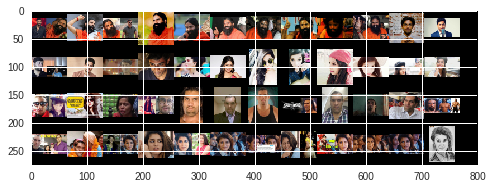

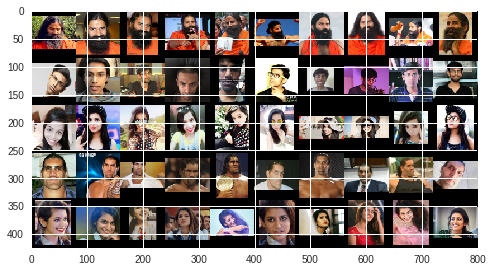

In [15]:
plt.imshow(cv2.imread(cf.data_dir+'IIC/train.png')[:,:,::-1])   ### training images examples
plt.show()
plt.imshow(cv2.imread(cf.data_dir+'IIC/test.png')[:,:,::-1])   ### training images examples
plt.show()

Create a list file of all training images with this shell command (assuming following directory structure):
```console
>ls
baba_ramdev  biswa  dhinchak_pooja  khali  priya_prakash

>ls dhinchak_pooja/ 
test  train

> ls dhinchak_pooja/train/
100.jpg   116.jpg   134.jpg  15.jpeg   164.jpg	 182.jpg   20.jpeg  217.jpg  234.jpg   250.jpeg  266.jpg  309.png  45.jpg  61.jpg  77.jpg  94.jpg ...............

> for f in *; do for g in $f/train/*; do echo $g; done; done > train.txt
```


Create a list file of all test images with this shell command

```console
> for f in *; do for g in $f/test/*; do echo $g; done; done > test.txt
```

In [0]:
# http://pytorch.org/
from os import path
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())

accelerator = 'cu80' if path.exists('/opt/bin/nvidia-smi') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.3.0.post4-{platform}-linux_x86_64.whl torchvision
import torch

Once you have the data, we can train/ fine-tune a network. Let's try doing prediction of Indian Internet Celebrity from noisy web data.

In [0]:
# Importing pytorch packages
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import torchvision
import torchvision.transforms as transforms
from torch.autograd import Variable
# Importing config.py file
import config as cf
from utils import *
from light_cnn import network_9layers
#from resnet import resnet18
from data_loader import *
from contrastive import *   ### implementation of contrastive loss
## Importing python packages
import os
import sys
import time
import datetime
import numpy as np
import math
import matplotlib.pyplot as plt

In [18]:
img_root = cf.data_dir+'IIC/'

train_list_file = cf.data_dir+'IIC_train.txt'   
val_list_file = cf.data_dir+'IIC_test.txt'      


train_image_list = [line.rstrip('\n') for line in open(train_list_file)]
val_image_list = [line.rstrip('\n') for line in open(val_list_file)]

print(len(train_image_list), len(val_image_list))

### Notice a new data loader for siamese networks. This gives the image pairs (image_1, image_2) and a label as input to the siamese networks.
### see siamese_data_loader.py for details

trainloader = torch.utils.data.DataLoader(custom_data_loader(img_root = img_root, image_list = train_list_file, crop=False,
                                                             resize = True, resize_shape=[128,128], classes = 'IIC'), 
                                           batch_size=8, num_workers=8, shuffle = True, pin_memory=False)

testloader = torch.utils.data.DataLoader(custom_data_loader(img_root = img_root, image_list = val_list_file, crop=False, mirror=False, 
                                                           resize = True, resize_shape=[128,128], classes = 'IIC'), 
                                           batch_size=10, num_workers=5, shuffle = False, pin_memory=False)

classes = ['baba_ramdev', 'biswa',  'dhinchak_pooja',  'khali',  'priya_prakash']

(1003, 50)


In [0]:
# Checking for GPU instance
use_cuda = torch.cuda.is_available()
#Intilizaing the accuracy value as zero
best_acc = 0
num_classes = 5

In [20]:
for i in trainloader:
  print(i)

image not none resizing
ERROR: couldn't find image ->  isfile data/IIC/dhinchak_pooja/train/212.jpg
ERROR: couldn't find image -> image_is_none data/IIC/dhinchak_pooja/train/212.jpg
creating a default image
image not none resizing
ERROR: couldn't find image ->  isfile data/IIC/dhinchak_pooja/train/150.jpg
ERROR: couldn't find image -> image_is_none data/IIC/dhinchak_pooja/train/150.jpg
creating a default image
image not none resizing
image not none resizing
image not none resizing
ERROR: couldn't find image ->  isfile data/IIC/dhinchak_pooja/train/70.jpg
ERROR: couldn't find image -> image_is_none data/IIC/dhinchak_pooja/train/70.jpg
creating a default image
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
ERROR: couldn't find image ->  isfile data/IIC/dhinchak_pooja/train/92.jpg
ERROR: couldn't find image -> image_is_none data/IIC/dhinchak_pooj

image not none resizing
ERROR: couldn't find image -> image_is_none data/IIC/dhinchak_pooja/train/42.jpg
creating a default image
image not none resizing
ERROR: couldn't find image -> image_is_none data/IIC/dhinchak_pooja/train/162.jpg
creating a default image
image not none resizing
ERROR: couldn't find image ->  isfile data/IIC/biswa/train/26.png
ERROR: couldn't find image -> image_is_none data/IIC/biswa/train/26.png
creating a default image
image not none resizing
ERROR: couldn't find image ->  isfile data/IIC/khali/train/122.jpg
ERROR: couldn't find image -> image_is_none data/IIC/khali/train/122.jpg
creating a default image
ERROR: couldn't find image ->  isfile data/IIC/baba_ramdev/train/50.jpeg
ERROR: couldn't find image -> image_is_none data/IIC/priya_prakash/train/110.jpg
ERROR: couldn't find image -> image_is_none data/IIC/baba_ramdev/train/50.jpeg
creating a default image
creating a default image
image not none resizing
image not none resizing
ERROR: couldn't find image ->  i

ERROR: couldn't find image -> image_is_none data/IIC/priya_prakash/train/58.jpg
creating a default image
image not none resizing
ERROR: couldn't find image ->  isfile data/IIC/dhinchak_pooja/train/227.jpg
ERROR: couldn't find image -> image_is_none data/IIC/dhinchak_pooja/train/227.jpg
creating a default image
image not none resizing
[
( 0 , 0 ,.,.) = 
    0    0    0  ...     0    0    0
    0    0    0  ...     0    0    0
    0    0    0  ...     0    0    0
      ...         ⋱        ...      
    0    0    0  ...     0    0    0
    0    0    0  ...     0    0    0
    0    0    0  ...     0    0    0
      ⋮  

( 1 , 0 ,.,.) = 
  230  231  230  ...   113  112  113
  230  231  231  ...   113  114  113
  231  231  230  ...   114  116  113
      ...         ⋱        ...      
   16   16   17  ...   111  112  112
   18   14   15  ...   111  111  109
   14   18   16  ...   111  111  113
      ⋮  

( 2 , 0 ,.,.) = 
  196  196  196  ...   196  196  196
  196  196  196  ...   196  196  1

creating a default image
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
[
( 0 , 0 ,.,.) = 
    0    0    0  ...     0    0    0
    0    0    0  ...     0    0    0
    0    0    0  ...     0    0    0
      ...         ⋱        ...      
    0    0    0  ...     0    0    0
    0    0    0  ...     0    0    0
    0    0    0  ...     0    0    0
      ⋮  

( 1 , 0 ,.,.) = 
   55   55   59  ...    69   82   93
   50   49   58  ...    55   76   89
   64   39   50  ...    47   55   78
      ...         ⋱        ...      
  126  120   91  ...    60   58   57
  135  126  117  ...    58   56   55
  143  136  146  ...    56   55   53
      ⋮  

( 2 , 0 ,.,.) = 
  253  254  252  ...   251  250  255
  254  205  119  ...    74   77  253
  254  187   75  ...    14   19  255
      ...         ⋱        ...      
  255  180  163  ...   247   52  253
  252

ERROR: couldn't find image ->  isfile data/IIC/dhinchak_pooja/train/126.jpg
ERROR: couldn't find image -> image_is_none data/IIC/dhinchak_pooja/train/126.jpg
creating a default image
image not none resizing
image not none resizing
ERROR: couldn't find image ->  isfile data/IIC/biswa/train/110.jpg
creating a default image
ERROR: couldn't find image -> image_is_none data/IIC/biswa/train/110.jpg
image not none resizing
ERROR: couldn't find image ->  isfile data/IIC/dhinchak_pooja/train/230.jpg
ERROR: couldn't find image -> image_is_none data/IIC/dhinchak_pooja/train/230.jpg
creating a default image
ERROR: couldn't find image ->  isfile data/IIC/khali/train/156.jpg
ERROR: couldn't find image -> image_is_none data/IIC/khali/train/156.jpg
creating a default image
[
( 0 , 0 ,.,.) = 
  141  143  150  ...   210  204  192
  103   85   95  ...   210  206  193
   85  125  112  ...   210  207  194
      ...         ⋱        ...      
  211  211  215  ...   201  185  201
  193  203  206  ...   210  

creating a default image
ERROR: couldn't find image ->  isfile data/IIC/khali/train/176.jpg
ERROR: couldn't find image -> image_is_none data/IIC/khali/train/176.jpg
creating a default image
ERROR: couldn't find image ->  isfile data/IIC/priya_prakash/train/170.jpg
ERROR: couldn't find image -> image_is_none data/IIC/priya_prakash/train/170.jpg
creating a default image
ERROR: couldn't find image ->  isfile data/IIC/biswa/train/131.jpg
ERROR: couldn't find image -> image_is_none data/IIC/biswa/train/131.jpg
creating a default image
image not none resizing
image not none resizing
[
( 0 , 0 ,.,.) = 
    0    0    0  ...     0    0    0
    0    0    0  ...     0    0    0
    0    0    0  ...     0    0    0
      ...         ⋱        ...      
    0    0    0  ...     0    0    0
    0    0    0  ...     0    0    0
    0    0    0  ...     0    0    0
      ⋮  

( 1 , 0 ,.,.) = 
   10    9    9  ...     9    9    9
    8    8    8  ...     9    9    9
    9    9    9  ...     8    8    9

image not none resizing
ERROR: couldn't find image ->  isfile data/IIC/dhinchak_pooja/train/68.jpg
ERROR: couldn't find image -> image_is_none data/IIC/dhinchak_pooja/train/68.jpg
creating a default image
image not none resizing
image not none resizing
image not none resizing
image not none resizing
ERROR: couldn't find image ->  isfile data/IIC/priya_prakash/train/7.jpg
ERROR: couldn't find image -> image_is_none data/IIC/priya_prakash/train/7.jpg
creating a default image
ERROR: couldn't find image ->  isfile data/IIC/dhinchak_pooja/train/243.jpg
ERROR: couldn't find image -> image_is_none data/IIC/dhinchak_pooja/train/243.jpg
creating a default image
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
ERROR: couldn't find image ->  isfile data/IIC/dhinchak_pooja/train/168.jpg
ERROR: couldn't find image -> image_is_none data/IIC/dhinchak_pooja/tra

ERROR: couldn't find image -> image_is_none data/IIC/dhinchak_pooja/train/273.jpg
creating a default image
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
ERROR: couldn't find image ->  isfile data/IIC/baba_ramdev/train/79.jpg
ERROR: couldn't find image -> image_is_none data/IIC/baba_ramdev/train/79.jpg
creating a default image
image not none resizing
image not none resizing
ERROR: couldn't find image ->  isfile data/IIC/dhinchak_pooja/train/173.jpeg
ERROR: couldn't find image -> image_is_none data/IIC/dhinchak_pooja/train/173.jpeg
creating a default image
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image

ERROR: couldn't find image -> image_is_none data/IIC/baba_ramdev/train/23.jpg
creating a default image
ERROR: couldn't find image ->  isfile data/IIC/dhinchak_pooja/train/254.jpg
ERROR: couldn't find image ->  isfile data/IIC/khali/train/257.jpg
ERROR: couldn't find image -> image_is_none data/IIC/khali/train/257.jpg
ERROR: couldn't find image -> image_is_none data/IIC/dhinchak_pooja/train/254.jpg
creating a default image
creating a default image
ERROR: couldn't find image ->  isfile data/IIC/biswa/train/169.jpg
ERROR: couldn't find image -> image_is_none data/IIC/biswa/train/169.jpg
creating a default image
ERROR: couldn't find image ->  isfile data/IIC/priya_prakash/train/119.jpg
ERROR: couldn't find image -> image_is_none data/IIC/priya_prakash/train/119.jpg
creating a default image
ERROR: couldn't find image ->  isfile data/IIC/khali/train/68.jpg
ERROR: couldn't find image ->  isfile data/IIC/dhinchak_pooja/train/131.jpg
ERROR: couldn't find image -> image_is_none data/IIC/khali/tr

image not none resizing
image not none resizing
image not none resizing
[
( 0 , 0 ,.,.) = 
  226  213  158  ...   199  197  190
  232  171  144  ...   196  193  189
  165  148  111  ...   196  193  191
      ...         ⋱        ...      
   91   91   91  ...    96   99  101
   86   87   88  ...    94   94   95
   82   83   85  ...    92   91   90
      ⋮  

( 1 , 0 ,.,.) = 
  250  250  250  ...   247  247  247
  250  250  250  ...   247  247  247
  250  250  250  ...   247  247  247
      ...         ⋱        ...      
  247  246  246  ...   128  140  201
  247  247  228  ...   127  134  145
  247  247  167  ...   120  126  125
      ⋮  

( 2 , 0 ,.,.) = 
  152  170  173  ...   205  186  178
  156  168  172  ...   198  182  182
  163  171  171  ...   194  178  190
      ...         ⋱        ...      
   94   76   74  ...   154  140  142
   89   73   70  ...   145  140  144
   87   70   66  ...   151  147  144
...     
      ⋮  

( 5 , 0 ,.,.) = 
    0    0    0  ...     0    0    0
  

creating a default image
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
ERROR: couldn't find image ->  isfile data/IIC/dhinchak_pooja/train/193.jpg
ERROR: couldn't find image -> image_is_none data/IIC/dhinchak_pooja/train/193.jpg
creating a default image
image not none resizing
image not none resizing
image not none resizing
ERROR: couldn't find image ->  isfile data/IIC/dhinchak_pooja/train/271.jpg
ERROR: couldn't find image -> image_is_none data/IIC/dhinchak_pooja/train/271.jpg
creating a default image
image not none resizing
image not none resizing
[
( 0 , 0 ,.,.) = 
   83   84   85  ...   207  208  208
   80   80   80  ...   207  207  208
   75   75   75  ...   205  206  206
      ...         ⋱        ...      
   92   88   87  ...    32   26   18
   85   81   80  ...    25   23   20
   85   82   72  ...    27   24   22
      ⋮  

( 1 , 0 ,.,.) = 
  208  209  208

image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
[
( 0 , 0 ,.,.) = 
   61   63   62  ...    55   54   53
   64   63   64  ...    55   54   54
   65   64   65  ...    54   53   54
      ...         ⋱        ...      
  174  205  215  ...   143  142  135
  202  217  212  ...   147  144  137
  209  214  212  ...   145  146  144
      ⋮  

( 1 , 0 ,.,.) = 
   11   11   11  ...     6    6    6
   11   11   11  ...     6    6    6
   11   11   11  ...     6    6    6
      ...         ⋱        ...      
   14   14   13  ...     8    8    8
   13   13   13  ...     9    7    7
   12   13   13  ...     8    8    6
      ⋮  

( 2 , 0 ,.,.) = 
  253  254  252  ...   254  250  254
  251  227  230  ...   221  226  254
  255  145  141  ...   106  135  254
      ...         ⋱        ...      
  253   49   38  ...    38   40  252
  249  177  175  ...   173  173  253
  252  254  253  

creating a default image
[
( 0 , 0 ,.,.) = 
   19   20   18  ...   203  202  200
   42   38   35  ...   205  203  201
   89   86   82  ...   206  203  203
      ...         ⋱        ...      
  202  188  178  ...   134  129  124
  202  193  175  ...   135  126  121
  200  195  174  ...   135  126  120
      ⋮  

( 1 , 0 ,.,.) = 
    0    0    0  ...     0    0    0
    0    0    0  ...     0    0    0
    0    0    0  ...     0    0    0
      ...         ⋱        ...      
    0    0    0  ...     0    0    0
    0    0    0  ...     0    0    0
    0    0    0  ...     0    0    0
      ⋮  

( 2 , 0 ,.,.) = 
  120  120  120  ...    97   95   93
  118  118  118  ...    98   96   94
  116  116  115  ...   102  100   98
      ...         ⋱        ...      
  168  168  167  ...   214  214  214
  169  169  169  ...   214  214  214
  169  169  169  ...   214  214  214
...     
      ⋮  

( 5 , 0 ,.,.) = 
  242  225  218  ...   242  241  241
  242  231  223  ...   241  234  237
  246  235  

image not none resizing
image not none resizing
image not none resizing
ERROR: couldn't find image ->  isfile data/IIC/dhinchak_pooja/train/238.jpg
ERROR: couldn't find image -> image_is_none data/IIC/dhinchak_pooja/train/238.jpg
creating a default image
ERROR: couldn't find image ->  isfile data/IIC/dhinchak_pooja/train/16.jpg
ERROR: couldn't find image -> image_is_none data/IIC/dhinchak_pooja/train/16.jpg
creating a default image
ERROR: couldn't find image ->  isfile data/IIC/biswa/train/198.jpg
ERROR: couldn't find image -> image_is_none data/IIC/biswa/train/198.jpg
creating a default image
ERROR: couldn't find image ->  isfile data/IIC/dhinchak_pooja/train/65.png
ERROR: couldn't find image -> image_is_none data/IIC/dhinchak_pooja/train/65.png
creating a default image
image not none resizing
image not none resizing
image not none resizing
ERROR: couldn't find image ->  isfile data/IIC/biswa/train/1.jpg
ERROR: couldn't find image -> image_is_none data/IIC/biswa/train/1.jpg
creating a

[
( 0 , 0 ,.,.) = 
  172  169  165  ...   255  255  255
  173  170  165  ...   255  255  255
  172  170  165  ...   255  255  255
      ...         ⋱        ...      
  110  107   78  ...   204  205  201
  109  109   79  ...   202  203  197
  108  107   80  ...   201  201  193
      ⋮  

( 1 , 0 ,.,.) = 
    0    0    0  ...     0    0    0
    0    0    0  ...     0    0    0
    0    0    0  ...     0    0    0
      ...         ⋱        ...      
    0    0    0  ...     0    0    0
    0    0    0  ...     0    0    0
    0    0    0  ...     0    0    0
      ⋮  

( 2 , 0 ,.,.) = 
  114  115  116  ...    95   92   91
  116  116  116  ...    95   93   92
  118  118  117  ...    96   95   93
      ...         ⋱        ...      
  166  183  146  ...   164  158  153
  165  173  100  ...   160  156  145
  148  141   75  ...   152  143  121
...     
      ⋮  

( 5 , 0 ,.,.) = 
    0    0    0  ...     0    0    0
    0    0    0  ...     0    0    0
    0    0    0  ...     0    0    0


image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
[
( 0 , 0 ,.,.) = 
  251  237  242  ...    98   97   96
  252  239  241  ...    98   97   96
  250  244  242  ...    98   97   96
      ...         ⋱        ...      
  113  116  118  ...   180  166  178
  116  117  119  ...   193  166  181
  113  124  118  ...   188  165  179
      ⋮  

( 1 , 0 ,.,.) = 
    0    0    0  ...     0    0    0
    0    0    0  ...     0    0    0
    0    0    0  ...     0    0    0
      ...         ⋱        ...      
    0    0    0  ...     0    0    0
    0    0    0  ...     0    0    0
    0    0    0  ...     0    0    0
      ⋮  

( 2 , 0 ,.,.) = 
    1    1    1  ...   236  235  234
    1    1    1  ...   235  235  234
    0    0    0  ...   234  234  234
      ...         ⋱        ...      
    3    4    3  ...    16   16   21
    3    3    3  ...    18   19   21
    2    4    3  

ERROR: couldn't find image ->  isfile data/IIC/dhinchak_pooja/train/170.jpg
ERROR: couldn't find image -> image_is_none data/IIC/dhinchak_pooja/train/170.jpg
creating a default image
ERROR: couldn't find image ->  isfile data/IIC/dhinchak_pooja/train/80.jpg
ERROR: couldn't find image -> image_is_none data/IIC/dhinchak_pooja/train/80.jpg
creating a default image
ERROR: couldn't find image ->  isfile data/IIC/priya_prakash/train/46.jpg
ERROR: couldn't find image -> image_is_none data/IIC/priya_prakash/train/46.jpg
creating a default image
image not none resizing
image not none resizing
ERROR: couldn't find image ->  isfile data/IIC/khali/train/95.jpeg
ERROR: couldn't find image -> image_is_none data/IIC/khali/train/95.jpeg
creating a default image
ERROR: couldn't find image ->  isfile data/IIC/biswa/train/97.jpg
ERROR: couldn't find image -> image_is_none data/IIC/biswa/train/97.jpg
creating a default image
ERROR: couldn't find image ->  isfile data/IIC/priya_prakash/train/86.jpg
ERROR: 

image not none resizing
image not none resizing
image not none resizing
ERROR: couldn't find image ->  isfile data/IIC/dhinchak_pooja/train/12.jpeg
ERROR: couldn't find image -> image_is_none data/IIC/dhinchak_pooja/train/12.jpeg
creating a default image
image not none resizing
image not none resizing
ERROR: couldn't find image ->  isfile data/IIC/biswa/train/204.jpg
ERROR: couldn't find image -> image_is_none data/IIC/biswa/train/204.jpg
creating a default image
image not none resizing
image not none resizing
image not none resizing
image not none resizing
ERROR: couldn't find image ->  isfile data/IIC/baba_ramdev/train/96.jpg
ERROR: couldn't find image -> image_is_none data/IIC/baba_ramdev/train/96.jpg
creating a default image
ERROR: couldn't find image ->  isfile data/IIC/dhinchak_pooja/train/270.jpg
ERROR: couldn't find image -> image_is_none data/IIC/dhinchak_pooja/train/270.jpg
creating a default image
[
( 0 , 0 ,.,.) = 
  254  246  247  ...   231  223  243
  253  204  205  ...  

image not none resizing
image not none resizing
ERROR: couldn't find image ->  isfile data/IIC/dhinchak_pooja/train/39.jpg
ERROR: couldn't find image -> image_is_none data/IIC/dhinchak_pooja/train/39.jpg
creating a default image
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
ERROR: couldn't find image ->  isfile data/IIC/priya_prakash/train/48.jpg
[
( 0 , 0 ,.,.) = 
  224  223  223  ...   206  205  203
  224  224  225  ...   205  207  204
  224  223  222  ...   205  209  206
      ...         ⋱        ...      
  154  174  150  ...   139  138  141
  176  176  133  ...   141  133  148
  161  170  177  ...   140  133  147
      ⋮  

( 1 , 0 ,.,.) = 
  181  220  234  ...    72   64   44
  183  232  237  ...   185  180  184
  186  233  236  ...   192  185  181
      ...         ⋱        ...      
  206  185  135  ...   195  198  198
  197  179  136  ...   196  196  199
 

creating a default image
ERROR: couldn't find image ->  isfile data/IIC/khali/train/131.png
ERROR: couldn't find image -> image_is_none data/IIC/khali/train/131.png
image not none resizing
image not none resizing
creating a default image
image not none resizing
[
( 0 , 0 ,.,.) = 
   62   63   66  ...    62   63   65
   62   63   69  ...    62   62   64
   62   63  111  ...    62   63   63
      ...         ⋱        ...      
  255  255  255  ...   115  249  250
  255  255  255  ...    98  250  253
  255  255  255  ...   184  254  253
      ⋮  

( 1 , 0 ,.,.) = 
    0    0    0  ...     0    0    0
    0    0    0  ...     0    0    0
    0    0    0  ...     0    0    0
      ...         ⋱        ...      
    0    0    0  ...     0    0    0
    0    0    0  ...     0    0    0
    0    0    0  ...     0    0    0
      ⋮  

( 2 , 0 ,.,.) = 
   44   45   46  ...    38   41   37
   44   45   46  ...    61   67   66
   46   47   47  ...    69   73   79
      ...         ⋱        ...    

ERROR: couldn't find image ->  isfile data/IIC/dhinchak_pooja/train/93.jpg
ERROR: couldn't find image -> image_is_none data/IIC/dhinchak_pooja/train/93.jpg
creating a default image
ERROR: couldn't find image ->  isfile data/IIC/khali/train/244.jpg
ERROR: couldn't find image -> image_is_none data/IIC/khali/train/244.jpg
creating a default image
ERROR: couldn't find image ->  isfile data/IIC/priya_prakash/train/156.jpg
ERROR: couldn't find image -> image_is_none data/IIC/priya_prakash/train/156.jpg
[
( 0 , 0 ,.,.) = 
    0    0    0  ...    21   22   21
    0    0    0  ...    23   23   23
    0    0    0  ...    25   24   23
      ...         ⋱        ...      
    4    4   12  ...   236  235  234
    9   10    8  ...   236  234  231
   14   11   10  ...   234  231  229
      ⋮  

( 1 , 0 ,.,.) = 
  196  196  196  ...   196  196  191
  196  196  196  ...   196  196  191
  196  196  196  ...   196  196  191
      ...         ⋱        ...      
  190  190  190  ...   196  196  192
  190  

ERROR: couldn't find image ->  isfile data/IIC/baba_ramdev/train/150.jpg
ERROR: couldn't find image -> image_is_none data/IIC/baba_ramdev/train/150.jpg
creating a default image
image not none resizing
ERROR: couldn't find image ->  isfile data/IIC/biswa/train/96.jpg
ERROR: couldn't find image -> image_is_none data/IIC/biswa/train/96.jpg
creating a default image
ERROR: couldn't find image ->  isfile data/IIC/baba_ramdev/train/109.jpg
ERROR: couldn't find image -> image_is_none data/IIC/baba_ramdev/train/109.jpg
creating a default image
image not none resizing
image not none resizing
ERROR: couldn't find image ->  isfile data/IIC/biswa/train/171.jpg
ERROR: couldn't find image -> image_is_none data/IIC/biswa/train/171.jpg
creating a default image
image not none resizing
image not none resizing
image not none resizing
ERROR: couldn't find image ->  isfile data/IIC/dhinchak_pooja/train/144.png
ERROR: couldn't find image -> image_is_none data/IIC/dhinchak_pooja/train/144.png
creating a defau

image not none resizing
ERROR: couldn't find image ->  isfile data/IIC/baba_ramdev/train/132.jpg
ERROR: couldn't find image -> image_is_none data/IIC/baba_ramdev/train/132.jpg
creating a default image
ERROR: couldn't find image ->  isfile data/IIC/biswa/train/63.jpg
ERROR: couldn't find image -> image_is_none data/IIC/biswa/train/63.jpg
creating a default image
ERROR: couldn't find image ->  isfile data/IIC/khali/train/133.jpg
ERROR: couldn't find image -> image_is_none data/IIC/khali/train/133.jpg
creating a default image
image not none resizing
image not none resizing
ERROR: couldn't find image ->  isfile data/IIC/khali/train/70.jpg
ERROR: couldn't find image -> image_is_none data/IIC/khali/train/70.jpg
creating a default image
image not none resizing
[
( 0 , 0 ,.,.) = 
    0    0    0  ...     0    0    0
    0    0    0  ...     0    0    0
    0    0    0  ...     0    0    0
      ...         ⋱        ...      
    0    0    0  ...     0    0    0
    0    0    0  ...     0    0 

image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
ERROR: couldn't find image ->  isfile data/IIC/priya_prakash/train/10.jpeg
ERROR: couldn't find image -> image_is_none data/IIC/priya_prakash/train/10.jpeg
creating a default image
image not none resizing
ERROR: couldn't find image ->  isfile data/IIC/dhinchak_pooja/train/34.jpg
ERROR: couldn't find image -> image_is_none data/IIC/dhinchak_pooja/train/34.jpg
creating a default image
image not none resizing
image not none resizing
image not none resizing
ERROR: couldn't find image ->  isfile data/IIC/dhinchak_pooja/train/196.jpg
ERROR: couldn't find image -> image_is_none data/IIC/dhinchak_pooja/train/196.jpg
creating a default image
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing

ERROR: couldn't find image -> image_is_none data/IIC/priya_prakash/train/87.jpg
creating a default image
ERROR: couldn't find image ->  isfile data/IIC/khali/train/9.jpg
ERROR: couldn't find image -> image_is_none data/IIC/khali/train/9.jpg
creating a default image
image not none resizing
ERROR: couldn't find image ->  isfile data/IIC/priya_prakash/train/59.jpg
ERROR: couldn't find image -> image_is_none data/IIC/priya_prakash/train/59.jpg
creating a default image
ERROR: couldn't find image ->  isfile data/IIC/biswa/train/92.jpeg
ERROR: couldn't find image -> image_is_none data/IIC/biswa/train/92.jpeg
ERROR: couldn't find image ->  isfile data/IIC/dhinchak_pooja/train/252.jpg
ERROR: couldn't find image -> image_is_none data/IIC/dhinchak_pooja/train/252.jpg
creating a default image
creating a default image
ERROR: couldn't find image ->  isfile data/IIC/khali/train/5.jpg
ERROR: couldn't find image -> image_is_none data/IIC/khali/train/5.jpg
creating a default image
image not none resizin

ERROR: couldn't find image ->  isfile data/IIC/priya_prakash/train/35.jpg
ERROR: couldn't find image -> image_is_none data/IIC/priya_prakash/train/35.jpg
creating a default image
ERROR: couldn't find image ->  isfile data/IIC/biswa/train/177.jpg
ERROR: couldn't find image -> image_is_none data/IIC/biswa/train/177.jpg
creating a default image
ERROR: couldn't find image ->  isfile data/IIC/dhinchak_pooja/train/114.jpg
ERROR: couldn't find image -> image_is_none data/IIC/dhinchak_pooja/train/114.jpg
creating a default image
image not none resizing
image not none resizing
image not none resizing
ERROR: couldn't find image ->  isfile data/IIC/dhinchak_pooja/train/151.jpg
ERROR: couldn't find image -> image_is_none data/IIC/dhinchak_pooja/train/151.jpg
creating a default image
ERROR: couldn't find image ->  isfile data/IIC/dhinchak_pooja/train/61.jpg
ERROR: couldn't find image -> image_is_none data/IIC/dhinchak_pooja/train/61.jpg
creating a default image
image not none resizing
image not non

[
( 0 , 0 ,.,.) = 
   38   38   38  ...   236  235  235
   38   38   38  ...   236  236  237
   38   38   38  ...   236  237  237
      ...         ⋱        ...      
   64   54   34  ...    94   96   98
   65   54   36  ...    93   95   95
   64   54   43  ...    91   92   93
      ⋮  

( 1 , 0 ,.,.) = 
   56   58   57  ...    39   40   38
   59   60   57  ...    40   41   39
   62   62   58  ...    41   43   42
      ...         ⋱        ...      
  138  138  113  ...   116  125  124
  120  119   87  ...   109  106  102
  115  107   70  ...   104   93   86
      ⋮  

( 2 , 0 ,.,.) = 
  190  110   93  ...    97   96  136
  184   64   44  ...    96   96  136
  171   46   46  ...    97   96  136
      ...         ⋱        ...      
  165   47   47  ...   161  172  199
  165   48   47  ...   165  164  179
  165   48   47  ...   167  160  177
...     
      ⋮  

( 5 , 0 ,.,.) = 
    0    0    0  ...     0    0    0
    0    0    0  ...     0    0    0
    0    0    0  ...     0    0    0


image not none resizing
image not none resizing
ERROR: couldn't find image ->  isfile data/IIC/dhinchak_pooja/train/119.jpg
ERROR: couldn't find image -> image_is_none data/IIC/dhinchak_pooja/train/119.jpg
creating a default image
image not none resizing
image not none resizing
image not none resizing
[
( 0 , 0 ,.,.) = 
   94   94   94  ...   136  136  136
   96   95   95  ...   136  136  136
   98   96   96  ...   136  136  136
      ...         ⋱        ...      
  127  107  129  ...    23   24   32
  125   87  109  ...    19   12   27
  109   91   84  ...    27   12   18
      ⋮  

( 1 , 0 ,.,.) = 
    0    0    0  ...     0    0    0
    0    0    0  ...     0    0    0
    0    0    0  ...     0    0    0
      ...         ⋱        ...      
    0    0    0  ...     0    0    0
    0    0    0  ...     0    0    0
    0    0    0  ...     0    0    0
      ⋮  

( 2 , 0 ,.,.) = 
    0    0    0  ...     0    0    0
    0    0    0  ...   116  116  116
    0    0    0  ...   255  25

image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
ERROR: couldn't find image ->  isfile data/IIC/khali/train/182.jpg
ERROR: couldn't find image -> image_is_none data/IIC/khali/train/182.jpg
creating a default image
ERROR: couldn't find image ->  isfile data/IIC/khali/train/14.jpg
ERROR: couldn't find image -> image_is_none data/IIC/khali/train/14.jpg
creating a default image
ERROR: couldn't find image ->  isfile data/IIC/biswa/train/205.jpg
ERROR: couldn't find image -> image_is_none data/IIC/biswa/train/205.jpg
creating a default image
ERROR: couldn't find image ->  isfile data/IIC/dhinchak_pooja/train/5.jpg
ERROR: couldn't find image -> image_is_none data/IIC/dhinchak_pooja/train

image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
ERROR: couldn't find image ->  isfile data/IIC/dhinchak_pooja/train/62.jpg
creating a default image
ERROR: couldn't find image -> image_is_none data/IIC/dhinchak_pooja/train/62.jpg
[
( 0 , 0 ,.,.) = 
  169  169  169  ...   121  116  112
  169  169  169  ...   117  114  109
  168  168  168  ...   112  112  106
      ...         ⋱        ...      
   26   30   35  ...    94   91   81
   28   29   30  ...    93   90   81
   31   30   30  ...    94   89   81
      ⋮  

( 1 , 0 ,.,.) = 
    0    0    0  ...     0    0    0
    0    0    0  ...     0    0    0
    0    0    0  ...     0    0    0
      ...         ⋱        ...      
    0    0    0  ...     0    0    0
    0    0    0  ...     0    0    0
    0    0    0  ...     0    0    0
      ⋮  

( 2 , 0 ,.,.) = 
    4    8    4  ...   201  190  187
    3    5    3  ...   166  160  154
    1   

image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
[
( 0 , 0 ,.,.) = 
  255    6   13  ...    27   25  251
  255    6   12  ...    34   27  252
  255    6   12  ...    46   42  250
      ...         ⋱        ...      
  252   51   50  ...   126  139  252
  252   49   50  ...   127  141  253
  251   48   51  ...   130  141  253
      ⋮  

( 1 , 0 ,.,.) = 
  241  240  244  ...   244  244  243
   72   87  122  ...    82   87   93
   40   71  102  ...    43   51   63
      ...         ⋱        ... 

creating a default image
image not none resizing
image not none resizing
image not none resizing
image not none resizing
ERROR: couldn't find image ->  isfile data/IIC/dhinchak_pooja/train/4.jpg
ERROR: couldn't find image -> image_is_none data/IIC/dhinchak_pooja/train/4.jpg
creating a default image
image not none resizing
ERROR: couldn't find image ->  isfile data/IIC/baba_ramdev/train/14.png
ERROR: couldn't find image -> image_is_none data/IIC/baba_ramdev/train/14.png
creating a default image
image not none resizing
image not none resizing
ERROR: couldn't find image ->  isfile data/IIC/khali/train/196.jpg
ERROR: couldn't find image -> image_is_none data/IIC/khali/train/196.jpg
creating a default image
ERROR: couldn't find image ->  isfile data/IIC/dhinchak_pooja/train/123.png
ERROR: couldn't find image -> image_is_none data/IIC/dhinchak_pooja/train/123.png
creating a default image
image not none resizing
ERROR: couldn't find image ->  isfile data/IIC/baba_ramdev/train/101.jpg
ERROR: c

ERROR: couldn't find image ->  isfile data/IIC/baba_ramdev/train/29.jpg
ERROR: couldn't find image -> image_is_none data/IIC/baba_ramdev/train/29.jpg
ERROR: couldn't find image ->  isfile data/IIC/dhinchak_pooja/train/105.jpg
creating a default image
ERROR: couldn't find image -> image_is_none data/IIC/dhinchak_pooja/train/105.jpg
creating a default image
ERROR: couldn't find image ->  isfile data/IIC/dhinchak_pooja/train/128.jpg
ERROR: couldn't find image -> image_is_none data/IIC/dhinchak_pooja/train/128.jpg
creating a default image
image not none resizing
ERROR: couldn't find image ->  isfile data/IIC/priya_prakash/train/62.jpg
ERROR: couldn't find image -> image_is_none data/IIC/priya_prakash/train/62.jpg
creating a default image
image not none resizing
[
( 0 , 0 ,.,.) = 
   23   10    7  ...   152  166  207
   11   10    8  ...   147  155  175
    7   10   10  ...   148  149  161
      ...         ⋱        ...      
  255  252  251  ...   106  100   98
  255  252  252  ...   149  

ERROR: couldn't find image ->  isfile data/IIC/dhinchak_pooja/train/184.jpg
ERROR: couldn't find image -> image_is_none data/IIC/dhinchak_pooja/train/184.jpg
creating a default image
image not none resizing
ERROR: couldn't find image ->  isfile data/IIC/dhinchak_pooja/train/232.jpg
ERROR: couldn't find image -> image_is_none data/IIC/dhinchak_pooja/train/232.jpg
creating a default image
image not none resizing
image not none resizing
image not none resizing
ERROR: couldn't find image ->  isfile data/IIC/khali/train/236.jpg
ERROR: couldn't find image -> image_is_none data/IIC/khali/train/236.jpg
creating a default image
image not none resizing
ERROR: couldn't find image ->  isfile data/IIC/dhinchak_pooja/train/206.jpg
ERROR: couldn't find image -> image_is_none data/IIC/dhinchak_pooja/train/206.jpg
creating a default image
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
ERROR: couldn't find i

image not none resizing
image not none resizing
ERROR: couldn't find image ->  isfile data/IIC/priya_prakash/train/123.jpg
ERROR: couldn't find image -> image_is_none data/IIC/priya_prakash/train/123.jpg
creating a default image
[
( 0 , 0 ,.,.) = 
  211  212  213  ...   209  208  208
  211  212  213  ...   209  208  208
  212  213  213  ...   209  209  209
      ...         ⋱        ...      
  217  217  217  ...   214  214  214
  217  217  217  ...   214  214  214
  217  217  217  ...   214  214  214
      ⋮  

( 1 , 0 ,.,.) = 
  123  136  138  ...   134   97   68
  123  136  138  ...   134   90   71
  123  136  138  ...   127   91   70
      ...         ⋱        ...      
   31   92   89  ...   228  222  227
   29   89   90  ...   216  224  229
   31   89   94  ...   190  228  230
      ⋮  

( 2 , 0 ,.,.) = 
    0    0    0  ...     0    0    0
    0    0    0  ...     0    0    0
    0    0    0  ...     0    0    0
      ...         ⋱        ...      
    0    0    0  ...     0    

image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
ERROR: couldn't find image ->  isfile data/IIC/dhinchak_pooja/train/250.jpeg
ERROR: couldn't find image -> image_is_none data/IIC/dhinchak_pooja/train/250.jpeg
creating a default image
image not none resizing
image not none resizing
ERROR: couldn't find image ->  isfile data/IIC/khali/train/107.jpg
ERROR: couldn't find image -> image_is_none data/IIC/khali/train/107.jpg
creating a default image
image not none resizing
ERROR: couldn't find image ->  isfile data/IIC/baba_ramdev/train/2.jpg
ERROR: couldn't find image -> image_is_none data/IIC/baba_ramdev/train/2.jpg
creating a default image
ERROR: couldn't find image ->  isfile data/IIC/dhinchak_pooja/train/147.jpg
ERROR: couldn't find image -> image_is_none data/IIC/dhinchak_pooja/train/147.jpg
ERROR: couldn't find image ->  isfile data/IIC/khali/train/233.png
ERROR: couldn't find image -> image_is_none data/IIC/khali/t

creating a default image
image not none resizing
image not none resizing
ERROR: couldn't find image ->  isfile data/IIC/dhinchak_pooja/train/102.jpeg
ERROR: couldn't find image -> image_is_none data/IIC/dhinchak_pooja/train/102.jpeg
creating a default image
[
( 0 , 0 ,.,.) = 
  144  145  145  ...   147  145  144
  145  145  146  ...   148  145  143
  146  146  147  ...   150  147  146
      ...         ⋱        ...      
  238  238  238  ...   235  233  232
  237  237  237  ...   232  232  236
  237  237  237  ...   230  231  234
      ⋮  

( 1 , 0 ,.,.) = 
    0    0    0  ...     0    0    0
    0    0    0  ...     0    0    0
    0    0    0  ...     0    0    0
      ...         ⋱        ...      
    0    0    0  ...     0    0    0
    0    0    0  ...     0    0    0
    0    0    0  ...     0    0    0
      ⋮  

( 2 , 0 ,.,.) = 
    0    0    0  ...     0    0    0
    0    0    0  ...     0    0    0
    0    0    0  ...     0    0    0
      ...         ⋱        ...      
 

ERROR: couldn't find image -> image_is_none data/IIC/biswa/train/183.jpg
creating a default image
image not none resizing
image not none resizing
[
( 0 , 0 ,.,.) = 
    0    0    0  ...     0    0    0
    0    0    0  ...     0    0    0
    0    0    0  ...     0    0    0
      ...         ⋱        ...      
    0    0    0  ...     0    0    0
    0    0    0  ...     0    0    0
    0    0    0  ...     0    0    0
      ⋮  

( 1 , 0 ,.,.) = 
   43   40   41  ...    11   11   15
   43   40   39  ...    11   11   13
   42   42   39  ...    12   11   13
      ...         ⋱        ...      
  143  143  143  ...   118   48    2
  142  143  143  ...   121  125   72
  149  154  151  ...   122  125  132
      ⋮  

( 2 , 0 ,.,.) = 
  154  155  154  ...   132  131  129
  154  154  154  ...   133  131  131
  154  153  154  ...   133  133  133
      ...         ⋱        ...      
   13   11   14  ...    13   13   15
   10    8   11  ...    14   13   13
    7    6    9  ...    15   12   11
..

ERROR: couldn't find image ->  isfile data/IIC/dhinchak_pooja/train/236.jpg
ERROR: couldn't find image -> image_is_none data/IIC/dhinchak_pooja/train/236.jpg
creating a default image
image not none resizing
ERROR: couldn't find image ->  isfile data/IIC/baba_ramdev/train/40.jpg
ERROR: couldn't find image -> image_is_none data/IIC/baba_ramdev/train/40.jpg
creating a default image
ERROR: couldn't find image ->  isfile data/IIC/biswa/train/115.jpg
ERROR: couldn't find image -> image_is_none data/IIC/biswa/train/115.jpg
creating a default image
image not none resizing
image not none resizing
[
( 0 , 0 ,.,.) = 
   40   49   35  ...    37   27   60
   47   46   45  ...    41   42   48
   48   38   54  ...    45   53   38
      ...         ⋱        ...      
   42   47   48  ...   126   74   27
   54   65   48  ...   156  134   92
   61   77   60  ...   137  141  139
      ⋮  

( 1 , 0 ,.,.) = 
  102  140   95  ...   114  113  103
  102  125   81  ...   117  115  106
  105  109   76  ...   12

image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
ERROR: couldn't find image ->  isfile data/IIC/priya_prakash/train/52.jpg
ERROR: couldn't find image -> image_is_none data/IIC/priya_prakash/train/52.jpg
creating a default image
ERROR: couldn't find image ->  isfile data/IIC/dhinchak_pooja/train/220.jpg
ERROR: couldn't find image -> image_is_none data/IIC/dhinchak_pooja/train/220.jpg
creating a default image
image not none resizing
image not none resizing
image not none resizing
image not none resizing
ERROR: couldn't find image ->  isfile data/IIC/priya_prakash/train/44.jpg
ERROR: couldn't find image -> image_is_none data/IIC/priya_prakash/train/44.jpg
creating a default image
image not none resizing
ERROR: couldn't find image ->  isfile data/IIC/dhinchak_pooja/train/272.png
ERROR: couldn't find image -> image_is_none data/IIC/dhinchak_pooja/tra

ERROR: couldn't find image ->  isfile data/IIC/khali/train/151.jpg
ERROR: couldn't find image -> image_is_none data/IIC/khali/train/151.jpg
creating a default image
ERROR: couldn't find image ->  isfile data/IIC/priya_prakash/train/74.jpg
ERROR: couldn't find image -> image_is_none data/IIC/priya_prakash/train/74.jpg
creating a default image
ERROR: couldn't find image ->  isfile data/IIC/baba_ramdev/train/114.jpg
ERROR: couldn't find image -> image_is_none data/IIC/baba_ramdev/train/114.jpg
creating a default image
ERROR: couldn't find image ->  isfile data/IIC/biswa/train/195.jpg
ERROR: couldn't find image -> image_is_none data/IIC/biswa/train/195.jpg
creating a default image
ERROR: couldn't find image ->  isfile data/IIC/khali/train/16.png
ERROR: couldn't find image -> image_is_none data/IIC/khali/train/16.png
creating a default image
ERROR: couldn't find image ->  isfile data/IIC/biswa/train/408.jpg
ERROR: couldn't find image -> image_is_none data/IIC/biswa/train/408.jpg
creating a 

image not none resizing
ERROR: couldn't find image ->  isfile data/IIC/dhinchak_pooja/train/157.jpg
ERROR: couldn't find image -> image_is_none data/IIC/dhinchak_pooja/train/157.jpg
creating a default image
image not none resizing
image not none resizing
ERROR: couldn't find image ->  isfile data/IIC/dhinchak_pooja/train/209.png
ERROR: couldn't find image -> image_is_none data/IIC/dhinchak_pooja/train/209.png
creating a default image
image not none resizing
image not none resizing
image not none resizing
ERROR: couldn't find image ->  isfile data/IIC/baba_ramdev/train/149.jpeg
ERROR: couldn't find image -> image_is_none data/IIC/baba_ramdev/train/149.jpeg
creating a default image
ERROR: couldn't find image ->  isfile data/IIC/dhinchak_pooja/train/132.jpg
ERROR: couldn't find image -> image_is_none data/IIC/dhinchak_pooja/train/132.jpg
creating a default image
image not none resizing
ERROR: couldn't find image ->  isfile data/IIC/dhinchak_pooja/train/222.jpg
ERROR: couldn't find image -

creating a default image
image not none resizing
ERROR: couldn't find image ->  isfile data/IIC/dhinchak_pooja/train/265.jpg
ERROR: couldn't find image -> image_is_none data/IIC/dhinchak_pooja/train/265.jpg
creating a default image
image not none resizing
image not none resizing
[
( 0 , 0 ,.,.) = 
    0    0    0  ...     0    0    0
    0    0    0  ...     0    0    0
    0    0    0  ...     0    0    0
      ...         ⋱        ...      
    0    0    0  ...     0    0    0
    0    0    0  ...     0    0    0
    0    0    0  ...     0    0    0
      ⋮  

( 1 , 0 ,.,.) = 
    0    0    0  ...     0    0    0
    0    0    0  ...     0    0    0
    0    0    0  ...     0    0    0
      ...         ⋱        ...      
    0    0    0  ...     0    0    0
    0    0    0  ...     0    0    0
    0    0    0  ...     0    0    0
      ⋮  

( 2 , 0 ,.,.) = 
    0    0    0  ...     0    0    0
    0    0    0  ...     0    0    0
    0    0    0  ...     0    0    0
      ...       

image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
ERROR: couldn't find image ->  isfile data/IIC/priya_prakash/train/33.jpg
ERROR: couldn't find image -> image_is_none data/IIC/priya_prakash/train/33.jpg
creating a default image
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
ERROR: couldn't find image ->  isfile data/IIC/dhinchak_pooja/train/262.jpg
ERROR: couldn't find image -> image_is_none data/IIC/dhinchak_pooja/train/262.jpg
creating a default image
[
( 0 , 0 ,.,.) = 
    0    0    0  ...     0    0    0
    0    0    0  ...     0    0    0
    0    0    0  ...     0    0    0
      ...         ⋱        ...      
    0    0    0  ...     0    0    0
    0    0    0  ...     0    0    0
    0    0    0  ...     0    0    0
      ⋮  

( 1 , 0 ,.,.) = 
  149  144  147  ...     1    1    1
  147  

ERROR: couldn't find image ->  isfile data/IIC/baba_ramdev/train/152.jpg
ERROR: couldn't find image -> image_is_none data/IIC/baba_ramdev/train/152.jpg
creating a default image
image not none resizing
[
( 0 , 0 ,.,.) = 
   73   75  239  ...   255  255  255
   73   72  240  ...   255  255  255
   73   67  233  ...   255  255  255
      ...         ⋱        ...      
   67   67   67  ...   149  143  131
   68   67   67  ...   160  147  154
   68   67   67  ...   144  148  151
      ⋮  

( 1 , 0 ,.,.) = 
    0    0    0  ...     0    0    0
    0    0    0  ...     0    0    0
    0    0    0  ...     0    0    0
      ...         ⋱        ...      
    0    0    0  ...     0    0    0
    0    0    0  ...     0    0    0
    0    0    0  ...     0    0    0
      ⋮  

( 2 , 0 ,.,.) = 
  190  190  190  ...    44   45   48
  193  193  193  ...    40   36   35
  195  195  195  ...    43   40   41
      ...         ⋱        ...      
  164  184  194  ...   157   63   69
  160  192  172  ... 

In [0]:
feature_net = network_9layers()   ### creates an object of this network architecture
feature_net = torch.load(cf.data_dir+'light_cnn/light_cnn_ckpt.t7')['net']

### starting the surgery
layers_to_remove = ['fc2']
for layers_ in layers_to_remove:        
    del(feature_net._modules[layers_])
    
#### old fc2 removed.

classifier = nn.Sequential(nn.Linear(256, 64), nn.BatchNorm1d(64), nn.ReLU(),
                           nn.Linear(64, 32), nn.BatchNorm1d(32), nn.ReLU(),
                           nn.Linear(32, num_classes))

### implanting a new fc2
feature_net.fc2 = classifier
if use_cuda:
    feature_net.cuda()
    


In [0]:
criterion = nn.CrossEntropyLoss()

In [0]:
def train(epoch):
    print('\nEpoch: %d' % epoch)
    feature_net.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        if use_cuda:
            inputs, targets = inputs.cuda(), targets.cuda()
        optimizer.zero_grad()
        inputs, targets = Variable(inputs), Variable(targets)
        outputs = feature_net(inputs)      ### notice that the pre-trained network has an implant classifier which directly outputs the 16 class prediction scores

        
        size_ = outputs.size()
        outputs_ = outputs.view(size_[0], num_classes)
        loss = criterion(outputs_, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.data[0]
        _, predicted = torch.max(outputs_.data, 1)
        total += targets.size(0)
        correct += predicted.eq(targets.data).cpu().sum()
        
        progress_bar(batch_idx, len(trainloader), 'Loss: %.3f | Acc: %.3f%% (%d/%d)'
                         % (train_loss/(batch_idx+1), 100.*correct/total, correct, total))
        
    train_loss_file.write('%d %.3f %.3f\n' %(epoch, train_loss/len(trainloader), 100.*correct/total))



In [0]:
def test(epoch):
    global best_acc
    feature_net.eval()
    test_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(testloader):
        if use_cuda:
            inputs, targets = inputs.cuda(), targets.cuda()
        inputs, targets = Variable(inputs, volatile=True), Variable(targets)
        outputs = feature_net(inputs)
        size_ = outputs.size()
        outputs_ = outputs.view(size_[0], num_classes)
        loss = criterion(outputs_, targets)

        test_loss += loss.data[0]
        _, predicted = torch.max(outputs_.data, 1)
        total += targets.size(0)
        correct += predicted.eq(targets.data).cpu().sum()
        
        progress_bar(batch_idx, len(testloader), 'Loss: %.3f | Acc: %.3f%% (%d/%d)'
                         % (test_loss/(batch_idx+1), 100.*correct/total, correct, total))
        
    val_loss_file.write('%d %.3f %.3f\n' %(epoch,  test_loss/len(testloader), 100.*correct/total))

    # Save checkpoint.
    acc = 100.*correct/total
    if acc > best_acc:
        print('Saving..')
        state = {
            'net': classifier,
            'acc': acc,
            'epoch': epoch,
        }
        if not os.path.isdir(cf.data_dir+'checkpoint'):
            os.mkdir(cf.data_dir+'checkpoint')
        torch.save(state, cf.data_dir+'checkpoint/checkpoint_ckpt.t7')
        best_acc = acc
    
    return test_loss/len(testloader)

In [0]:
experiment = 'lightnet_finetune_IIC'
train_loss_file = open(cf.data_dir+experiment+"train_loss.txt", "w", 0)
val_loss_file = open(cf.data_dir+experiment+"val_loss.txt", "w", 0)

In [0]:
layers_to_finetune = [{'params': feature_net.features.parameters()}, 
                      {'params': feature_net.fc1.parameters()},
                      {'params':feature_net.fc2.parameters()}]

(256, 346, 3)


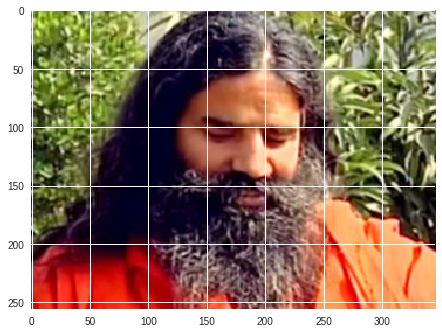

In [27]:

im = (cv2.imread('data/IIC/baba_ramdev/test/103.jpg')[:,:,::-1])
print(im.shape)
plt.imshow(im)

In [29]:
best_acc = 0
optimizer = optim.Adam(layers_to_finetune, lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=2, verbose=True)   #### dynamic LR scheduler
for epoch in range(0, 1):
    train(epoch)
    test_loss = test(epoch)
    scheduler.step(test_loss)
    
train_loss_file.close()
val_loss_file.close()


Epoch: 0
ERROR: couldn't find image ->  isfile data/IIC/dhinchak_pooja/train/210.jpg
ERROR: couldn't find image -> image_is_none data/IIC/dhinchak_pooja/train/210.jpg
creating a default image
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
ERROR: couldn't find image ->  isfile data/IIC/dhinchak_pooja/train/214.jpg
ERROR: couldn't find image -> image_is_none data/IIC/dhinchak_pooja/train/214.jpg
creating a default image
image not none resizing
image not none resizing
image not none resizing
image not none resizing
ERROR: couldn't find image ->  isfile data/IIC/dhinchak_pooja/train/254.jpg
ERROR: couldn't find image -> image_is_none data/IIC/dhinchak_pooja/train/254.jpg
creating a default image
image not none resizing
image not none resizing
image not none resizing
image not none resizing
ERROR: couldn't find image ->  isfile data/IIC/dhinchak_pooja/train/120.jpg
ERROR: couldn't find image -> image_is_none data/IIC/

ERROR: couldn't find image ->  isfile data/IIC/dhinchak_pooja/train/132.jpg
ERROR: couldn't find image -> image_is_none data/IIC/dhinchak_pooja/train/132.jpg
creating a default image
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
ERROR: couldn't find image ->  isfile data/IIC/priya_prakash/train/188.jpg
ERROR: couldn't find image -> image_is_none data/IIC/priya_prakash/train/188.jpg
creating a default image
ERROR: couldn't find image ->  isfile data/IIC/biswa/train/182.jpg
ERROR: couldn't find image -> image_is_none data/IIC/biswa/train/182.jpg
creating a default image
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none 

image not none resizing
ERROR: couldn't find image ->  isfile data/IIC/dhinchak_pooja/train/193.jpg
ERROR: couldn't find image -> image_is_none data/IIC/dhinchak_pooja/train/193.jpg
creating a default image
image not none resizing
image not none resizing
image not none resizing
ERROR: couldn't find image ->  isfile data/IIC/dhinchak_pooja/train/240.jpg
ERROR: couldn't find image -> image_is_none data/IIC/dhinchak_pooja/train/240.jpg
creating a default image
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
ERROR: couldn't find image ->  isfile data/IIC/dhinchak_pooja/train/119.jpg
ERROR: couldn't find image -> image_is_none data/IIC/dhinchak_pooja/train/119.jpg
creating a default image
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
ERROR: couldn't find image ->  isfile data/IIC/dhinchak_pooja/train/262.jpg
ERROR: couldn't

image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none r

image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
ERROR: couldn't find image ->  isfile data/IIC/dhinchak_pooja/train/156.jpg
ERROR: couldn't find image -> image_is_none data/IIC/dhinchak_pooja/train/156.jpg
creating a default image
ERROR: couldn't find image ->  isfile data/IIC/dhinchak_pooja/train/238.jpg
ERROR: couldn't find image -> image_is_none data/IIC/dhinchak_pooja/train/238.jpg
creating a default image
image not none resizing
ERROR: couldn't find image ->  isfile data/IIC/dhinchak_pooja/train/176.jpg
ERROR: couldn't find image -> image_is_none data/IIC/dhinchak_pooja/train/176.jpg
creating a default image
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
ERROR: couldn't find image ->  isfile data/IIC/dhinchak_pooja/train/216.jpg
ERROR: couldn't find image -> image_is_none data/IIC/dhinchak_p

ERROR: couldn't find image -> image_is_none data/IIC/dhinchak_pooja/train/15.jpeg
creating a default image
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
ERROR: couldn't find image ->  isfile data/IIC/dhinchak_pooja/train/275.jpg
ERROR: couldn't find image -> image_is_none data/IIC/dhinchak_pooja/train/275.jpg
creating a default image
image not none

image not none resizing
ERROR: couldn't find image ->  isfile data/IIC/dhinchak_pooja/train/225.jpg
ERROR: couldn't find image -> image_is_none data/IIC/dhinchak_pooja/train/225.jpg
creating a default image
image not none resizing
image not none resizing
image not none resizing
ERROR: couldn't find image ->  isfile data/IIC/dhinchak_pooja/train/39.jpg
ERROR: couldn't find image -> image_is_none data/IIC/dhinchak_pooja/train/39.jpg
creating a default image
image not none resizing
ERROR: couldn't find image ->  isfile data/IIC/dhinchak_pooja/train/227.jpg
ERROR: couldn't find image -> image_is_none data/IIC/dhinchak_pooja/train/227.jpg
creating a default image
image not none resizing
ERROR: couldn't find image ->  isfile data/IIC/dhinchak_pooja/train/220.jpg
ERROR: couldn't find image -> image_is_none data/IIC/dhinchak_pooja/train/220.jpg
creating a default image
ERROR: couldn't find image ->  isfile data/IIC/dhinchak_pooja/train/92.jpg
ERROR: couldn't find image -> image_is_none data/II

image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
ERROR: couldn't find image ->  isfile data/IIC/priya_prakash/train/97.jpeg
ERROR: couldn't find image -> image_is_none data/IIC/priya_prakash/train/97.jpeg
creating a default image
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
ERROR: couldn't find image ->  isfile data/IIC/dhinchak_pooja/train/157.jpg
ERROR: couldn't find image -> image_is_none data/IIC/dhinchak_pooja/train/157.jpg
creating a default image
image not none resizing
image not none resizing
image not none resizing
ERROR: couldn't find image ->  isfile data/IIC/dhinchak_pooja/train/66.jpg
ERROR: couldn't find image -> image_is_none data/IIC/dhinchak_pooja/train/66.jpg


image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
ERROR: couldn't find image ->  isfile data/IIC/biswa/train/165.png
ERROR: couldn't find image -> image_is_none data/IIC/biswa/train/165.png
creating a default image
ERROR: couldn't find image ->  isfile data/IIC/dhinchak_pooja/train/209.png
ERROR: couldn't find image -> image_is_none data/IIC/dhinchak_pooja/train/209.png
creating a default image
ERROR: couldn't find image ->  isfile data/IIC/dhinchak_pooja/train/4.jpg
ERROR: couldn't find image -> image_is_none data/IIC/dhinchak_pooja/train/4.jpg
creating a default image
image not none resizing
image not none resizing
ERROR: couldn't find image ->  isfile data/IIC/priya_prakash/train/87.jpg
ERROR: couldn't find image -> image_is_none data/IIC/priya_prakash/train/87.jpg
creating a default image
image not none resizing
image not none resizing
image not none resizing
image not none resizing
ERROR: couldn't find image -> 

image not none resizing
image not none resizing
ERROR: couldn't find image ->  isfile data/IIC/dhinchak_pooja/train/245.jpg
ERROR: couldn't find image -> image_is_none data/IIC/dhinchak_pooja/train/245.jpg
creating a default image
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
ERROR: couldn't find image ->  isfile data/IIC/dhinchak_pooja/train/258.jpg
ERROR: couldn't find image -> image_is_none data/IIC/dhinchak_pooja/train/258.jpg
creating a default image
image not none resizing
image not none resizing
ERROR: couldn't find image ->  isfile data/IIC/priya_prakash/train/169.jpeg
ERROR: couldn't find image -> image_is_none data/IIC/p

image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
ERROR: couldn't find image ->  isfile data/IIC/dhinchak_pooja/train/165.jpg
ERROR: couldn't find image -> image_is_none data/IIC/dhinchak_pooja/train/165.jpg
creating a default image
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
ERROR: couldn't find image ->  isfile data/IIC/dhinchak_pooja/train/57.jpg
ERROR: couldn't find image -> image_is_none da

image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
ERROR: couldn't find image ->  isfile data/IIC/biswa/train/204.jpg
ERROR: couldn't find image -> image_is_none data/IIC/biswa/train/204.jpg
creating a default image
ERROR: couldn't find image ->  isfile data/IIC/dhinchak_pooja/train/221.jpg
ERROR: couldn't find image -> image_is_none data/IIC/dhinchak_pooja/train/221.jpg
creating a default image
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
imag

image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
ERROR: couldn't find image ->  isfile data/IIC/priya_prakash/train/136.jpg
ERROR: couldn't find image -> image_is_none data/IIC/priya_prakash/train/136.jpg
creating a default image
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
ERROR: couldn't find image ->  isfile data/IIC/dhinchak_pooja/train/64.jpg
ERROR: couldn't find image -> image_is_none data/IIC/dhinchak_pooja/train/64.jpg
creating a default image
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none

image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
ERROR: couldn't find image ->  isfile data/IIC/dhinchak_pooja/train/219.jpg
ERROR: couldn't find image -> image_is_none data/IIC/dhinchak_pooja/train/219.jpg
creating a default image
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
ERROR: couldn't find image ->  isfile data/IIC/dhinchak_pooja/train/5.jpg
ERROR: couldn't find image -> image_is_none data/IIC/dhinchak_pooja/train/5.jpg
creating a defa

creating a default image
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
ERROR: couldn't find image ->  isfile data/IIC/priya_prakash/train/179.jpg
ERROR: couldn't find image -> image_is_none data/IIC/priya_prakash/train/179.jpg
creating a default image
image not none resizing
ERROR: couldn't find image ->  isfile data/IIC/dhinchak_pooja/train/62.jpg
ERROR: couldn't find image -> image_is_none data/IIC/dhinchak_pooja/train/62.jpg
creating a default image
image not none resizing
image not none resizing
ERROR: couldn't find image ->  isfile data/IIC/dhinchak_pooja/train/173.jpeg
ERROR: couldn't find image -> image_is_none data/IIC/dhinchak_pooja/train/173.jpeg
creating a default image
ERROR: couldn't find image ->  isfile data/IIC/dhinchak_pooja/train/250.jpeg
ERROR: couldn't find image -> image_is_none data/IIC/dhinchak_pooja/train/250.jpeg
creating a default image
image not none resizing
ima

image not none resizing
image not none resizing
image not none resizing
image not none resizing
ERROR: couldn't find image ->  isfile data/IIC/dhinchak_pooja/train/205.jpg
ERROR: couldn't find image -> image_is_none data/IIC/dhinchak_pooja/train/205.jpg
creating a default image
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
ERROR: couldn't find image ->  isfile data/IIC/priya_prakash/train/189.jpg
ERROR: couldn't find image -> image_is_none da

image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
ERROR: couldn't find image ->  isfile data/IIC/dhinchak_pooja/train/144.png
ERROR: couldn't find image -> image_is_none data/IIC/dhinchak_pooja/train/144.png
creating a default image
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
ERROR: couldn't find image ->  isfile data/IIC/dhinchak_pooja/train/309.png
ERROR: couldn't find image -> image_is_none data/IIC/dhinchak_pooja/train/309.png
creating a default image
ERROR: couldn't find image ->  isfile data/IIC/biswa/train/170.png
ERROR: couldn't find image -> image_is_none data/IIC/biswa/train/170.png
creating a default image
image not none resizing
image not none resizing
image not none resizing
ERROR: couldn't find image ->  isfile data/IIC/dhinchak_pooja/train/61.jpg
ERROR: cou

creating a default image
image not none resizing
image not none resizing
 [==================================>] | Loss: 1.538 | Acc: 32.104% (322/1003)   126/126 
ERROR: couldn't find image ->  isfile data/IIC/khali/test/2.jpg
ERROR: couldn't find image -> image_is_none data/IIC/khali/test/2.jpg
creating a default image
ERROR: couldn't find image ->  isfile data/IIC/dhinchak_pooja/test/118.jpg
ERROR: couldn't find image -> image_is_none data/IIC/dhinchak_pooja/test/118.jpg
creating a default image
ERROR: couldn't find image ->  isfile data/IIC/biswa/test/107.jpg
ERROR: couldn't find image -> image_is_none data/IIC/biswa/test/107.jpg
ERROR: couldn't find image ->  isfile data/IIC/priya_prakash/test/108.jpg
creating a default image
ERROR: couldn't find image -> image_is_none data/IIC/priya_prakash/test/108.jpg
creating a default image
ERROR: couldn't find image ->  isfile data/IIC/khali/test/22.png
ERROR: couldn't find imag

image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
 [============================>......] | Loss: 1.555 | Acc: 32.000% (16/50)      5/5 
Saving..


1 1


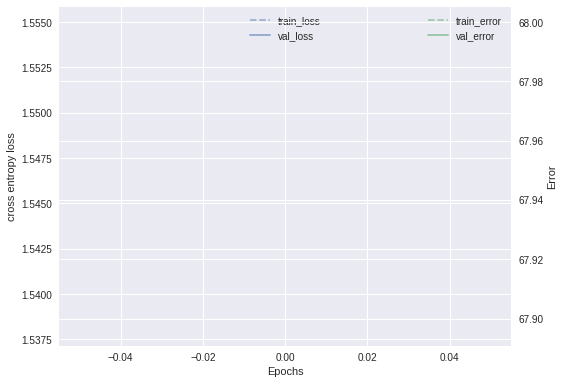

In [30]:
training_curves(cf.data_dir+experiment)

In [0]:
classifier = torch.load(cf.data_dir+'checkpoint/checkpoint_ckpt.t7')['net'].eval()

In [0]:
def eval():
    feature_net.eval()
    
    #testloader = torch.utils.data.DataLoader(custom_data_loader(img_root = img_root, image_list = val_list_file, crop=False, mirror=False, 
    #                                                      resize = True, resize_shape=[128,128], classes='IIC'), 
    #                                      batch_size=1, num_workers=1, shuffle = False, pin_memory=True)
    correct = 0
    total = 0
    conf_mat = np.zeros((num_classes, num_classes))
    total_ = np.zeros((num_classes))
    wrong_predictions = []
    for batch_idx, (inputs, targets) in enumerate(testloader):
        #if use_cuda:
            #inputs, targets = inputs.cuda(), targets.cuda()
        inputs, targets = Variable(inputs, volatile=True), Variable(targets)
        outputs = feature_net(inputs)
        size_ = outputs.size()
        outputs_ = outputs.view(size_[0], num_classes)
        _, predicted = torch.max(outputs_.data, 1)
        total += targets.size(0)
        correct += predicted.eq(targets.data).cpu().sum()
        prediction = predicted.cpu().numpy()[0]
        targets = targets.data.cpu().numpy()[0]
        total_[targets] +=1
        conf_mat[predicted, targets] +=1
        
        if prediction != targets:
            wrong_predictions += [[inputs, prediction, targets]]
        
    for k in range(num_classes):
        conf_mat[:,k] /= total_[k]
    return conf_mat, 100.*correct/total, wrong_predictions
    

In [33]:
use_cuda

False

In [34]:
conf, acc, wrong_predictions = eval()
print('Accuracy:', acc, '%')

image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none r

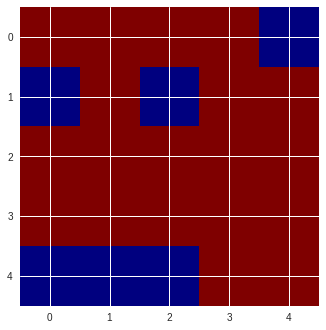

In [35]:
plt.imshow(conf, cmap='jet', vmin=0, vmax = 1)
plt.show()

('biswa', 'confused with', 'dhinchak_pooja')


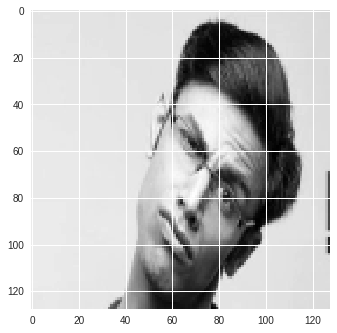

('khali', 'confused with', 'biswa')


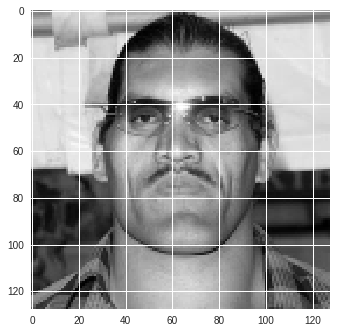

In [36]:
for w in wrong_predictions:
    print(classes[w[2]], 'confused with', classes[w[1]])
    plt.imshow(w[0][0][0].data.cpu().numpy(), cmap='gray')
    plt.show()

Note that, this is the performance obtained from just 10 minutes of data collection.

**Exercise**

Now repeat this experiment with the classes from IMFDB 16. Note that training set is the new set that you have crawled from the web and the test set is at cf.data_dir+'IMFDB_test.txt'

In [37]:
img_root = cf.data_dir+'YOUR_TRAIN_DATA_ROOT_DIR/'    #### replace this string with your training directory root

train_list_file = cf.data_dir+'YOUR_TRAINING_IMAGES_LIST.txt'   #### list of (atleast) 10000 images that you have collected from the web
val_list_file = cf.data_dir+'IMFDB_test.txt'      #### 1095 images for validation


train_image_list = [line.rstrip('\n') for line in open(train_list_file)]
val_image_list = [line.rstrip('\n') for line in open(val_list_file)]

print(len(train_image_list), len(val_image_list))

trainloader = torch.utils.data.DataLoader(custom_data_loader(img_root = img_root, image_list = train_list_file, crop=False,
                                                             resize = True, resize_shape=[128,128]), 
                                          batch_size=32, num_workers=16, shuffle = True, pin_memory=False)

testloader = torch.utils.data.DataLoader(custom_data_loader(img_root = img_root, image_list = val_list_file, crop=False, mirror=False, 
                                                           resize = True, resize_shape=[128,128]), 
                                         batch_size=10, num_workers=5, shuffle = False, pin_memory=False)

classes = ['AamairKhan', 'Rimisen', 'Kajol', 'KareenaKapoor','RishiKapoor', 'AmrishPuri', 'AnilKapoor', 'AnupamKher', 'BomanIrani', 'HrithikRoshan', 'KajalAgarwal', 'KatrinaKaif', 'Madhavan', 'MadhuriDixit', 'Umashri', 'Trisha']

IOError: ignored

In [0]:
best_acc = 0
num_classes = 16

In [0]:
feature_net = network_9layers()   ### creates an object of this network architecture
feature_net = torch.load(cf.data_dir+'light_cnn/light_cnn_ckpt.t7')['net']

### starting the surgery
layers_to_remove = ['fc2']
for layers_ in layers_to_remove:        
    del(feature_net._modules[layers_])
    
#### old fc2 removed.

classifier = nn.Sequential(nn.Linear(256, 64), nn.BatchNorm1d(64), nn.ReLU(),
                           nn.Linear(64, 32), nn.BatchNorm1d(32), nn.ReLU(),
                           nn.Linear(32, num_classes))

### implanting a new fc2
feature_net.fc2 = classifier
if use_cuda:
    feature_net.cuda()

In [0]:
experiment = 'lightnet_finetune_WEBIMFDB'
train_loss_file = open(cf.data_dir+experiment+"train_loss.txt", "w", 0)
val_loss_file = open(cf.data_dir+experiment+"val_loss.txt", "w", 0)

In [0]:
layers_to_finetune = [{'params': feature_net.features.parameters()}, 
                      {'params': feature_net.fc1.parameters()},
                      {'params':feature_net.fc2.parameters()}]

In [0]:
best_acc = 0
optimizer = optim.Adam(layers_to_finetune, lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=2, verbose=True)   #### dynamic LR scheduler
for epoch in range(0, 30):
    train(epoch)
    test_loss = test(epoch)
    scheduler.step(test_loss)
    
train_loss_file.close()
val_loss_file.close()

In [0]:
training_curves(cf.data_dir+experiment)

In [0]:
classifier = torch.load(cf.data_dir+'checkpoint/checkpoint_ckpt.t7')['net'].eval()

In [0]:
conf, acc, wrong_predictions = eval()
print('Accuracy:', acc, '%')

In [0]:
plt.imshow(conf, cmap='jet', vmin=0, vmax = 1)
plt.show()

In [0]:
for w in wrong_predictions:
    print(classes[w[2]], 'confused with', classes[w[1]])
    plt.imshow(w[0][0][0].data.cpu().numpy(), cmap='gray')
    plt.show()